In [1]:
import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import powerlaw
import community as community_louvain
from fa2 import ForceAtlas2

# !pip install pyvis
from pyvis.network import Network

from pathlib import Path

For now I will work with the total relationships. I load the csv in a pandas dataframe:

In [2]:
rel_path = Path.cwd() / 'Relationships'

relationships_pd = pd.read_csv(rel_path.as_posix()+ '/' +'total_relationships.csv', index_col=0)

Now we can create a network by [using the relationship dataframe as edgelist](https://networkx.org/documentation/stable/reference/generated/networkx.convert_matrix.from_pandas_edgelist.html) and the weight as an edge attribute to show relationship strength:

In [3]:
G = nx.from_pandas_edgelist(relationships_pd,
                           source='source',
                           target='target',
                           edge_attr='weight',
                           create_using=nx.Graph())

Initial network statistics, number of nodes, edges, etc:

In [4]:
print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")

Number of nodes: 253
Number of edges: 2202


### Connected component  

Since the graph is undirected, we use the function [`connected_components`](https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.components.connected_components.html)

In [5]:
Gcc = list( nx.connected_components(G))
Gcc = sorted(Gcc, key=len, reverse=True)
print(f"Number of connected components: {len(Gcc)}")

Number of connected components: 1


There exists only 1 connected component, so the following uses the graph `G`.

### Degree distribution

In [6]:
degrees_dist = np.array([ degree for (node, degree) in G.degree() ])

bins  = np.arange(degrees_dist.min(), degrees_dist.max()+1, 1)
hist, edges = np.histogram( degrees_dist, bins=bins )

A random network with the same probability and number of nodes with the south park network can be created for comparison:

In [7]:
N = G.number_of_nodes()
k_avg = degrees_dist.mean() # average degree

# probability p for E-R network
p = k_avg/(N-1)

# Generate directed ER network of same size and p 
G_er = nx.erdos_renyi_graph(n=N, p=p)

# Degree distribution for ER network
degrees_dist_er = np.array([deg for (node, deg) in G_er.degree()])

# Histogram for ER network
hist_er, edges_er = np.histogram(degrees_dist_er, bins=np.arange( degrees_dist_er.min(), degrees_dist_er.max()+1,1 ))

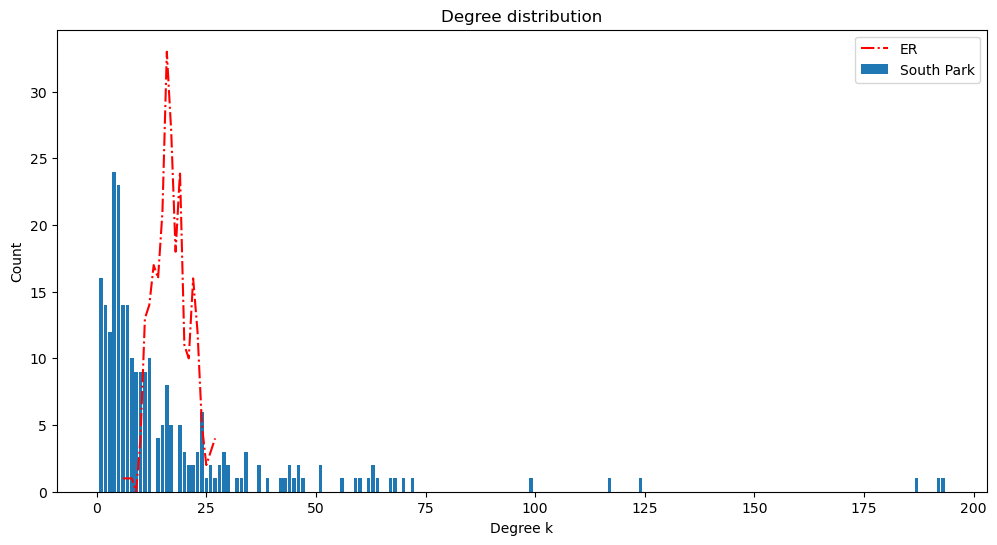

In [8]:
fig = plt.figure(figsize=(12,6))

plt.bar(edges[:-1], hist, width=0.8, label='South Park' )
plt.plot(edges_er[:-1], hist_er, 'r-.', label='ER')
plt.xlabel('Degree k')
plt.ylabel('Count')
plt.title('Degree distribution')


plt.legend()
plt.show()

Comparing the ER netowkr with the South Park network, we can see that the later is a real world network, since it allows for large degrees and also that the majority of degrees are smaller in value than the average degree.

To get a better sense of the regime the network is in, we can plot the degree distribution in logarithmic scale. We also use the `powerlaw` library to estimate the degree exponent.

In [9]:
power_law_fit = powerlaw.Fit(degrees_dist)

degree_exponent = power_law_fit.alpha
print(f"The degree exponent is estimated: {np.round(degree_exponent,4)}")

The degree exponent is estimated: 2.3812


Calculating best minimal value for power law fit
C:\Users\user\anaconda3\lib\site-packages\powerlaw.py:699: RuntimeWarning: invalid value encountered in divide
  (CDF_diff**2) /


Since the estimated degree exponent  has value $\gamma$: $2 < \gamma < 3$, the network is in the [scale-free regime](http://networksciencebook.com/chapter/4#degree-exponent). Large hubs are expected to exist, which decreases the distances between the nodes and the [Ultra-Small World](http://networksciencebook.com/chapter/4#ultra-small) phenomenon is observed.

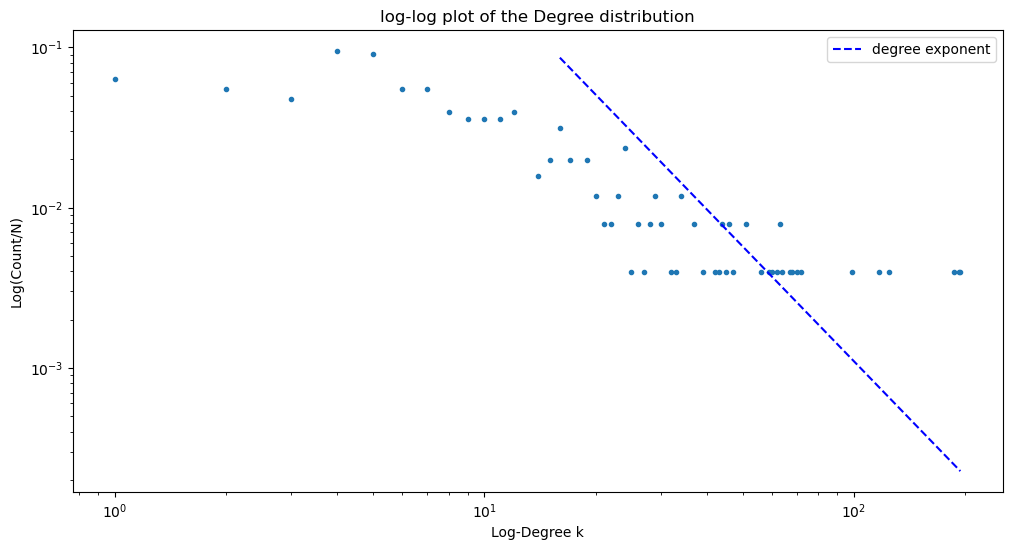

In [10]:
fig = plt.figure(figsize=(12,6))

plt.loglog(edges[:-1], hist/G.number_of_nodes(), '.' )
power_law_fit.power_law.plot_pdf(color= 'b',linestyle='--',label='degree exponent')

plt.xlabel('Log-Degree k')
plt.ylabel('Log(Count/N)')
plt.title('log-log plot of the Degree distribution')
plt.legend()

plt.show()

### Centrality measures (again)  

We can use centrality measures to find the most popular characters, since now the way the network has been created is more realistic, based on interactions between characters between scenes.

In [11]:
def plot_top_characters_centrality(centrality_dict, top_n):
    a = dict(sorted( centrality_dict.items(), key=lambda x: x[1], reverse=True )[:top_n])
    
    fig, ax = plt.subplots(1,1) 
    ax.bar(np.arange(len(list(a.values()))), list(a.values()))

    # Set number of ticks for x-axis
    ax.set_xticks( np.arange(len(list(a.keys()))) )
    # Set ticks labels for x-axis
    ax.set_xticklabels(list(a.keys()), rotation=60, fontsize=10)
    

In [12]:
# Top characters to show centralities
top_n = 10

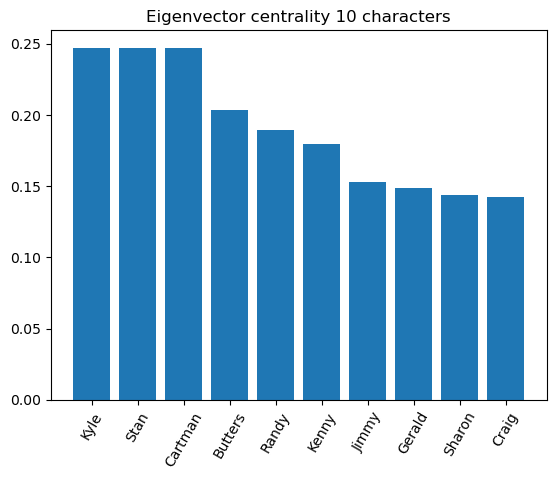

In [13]:
eigen_centr = nx.eigenvector_centrality(G)

plot_top_characters_centrality(eigen_centr, top_n)
plt.title(f'Eigenvector centrality {top_n} characters')
plt.show()

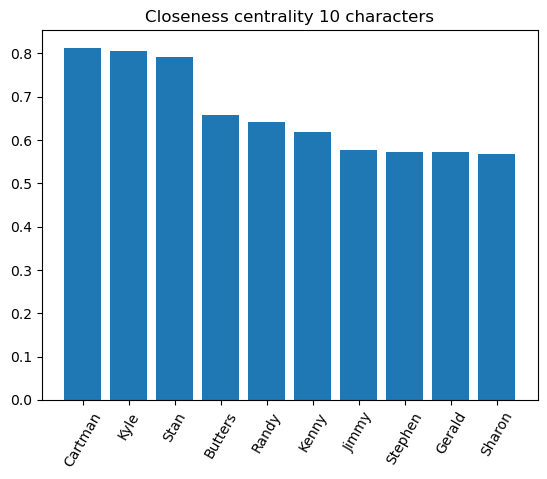

In [14]:
closeness_centr = nx.closeness_centrality(G)


plot_top_characters_centrality(closeness_centr, top_n)
plt.title(f'Closeness centrality {top_n} characters')
plt.show()

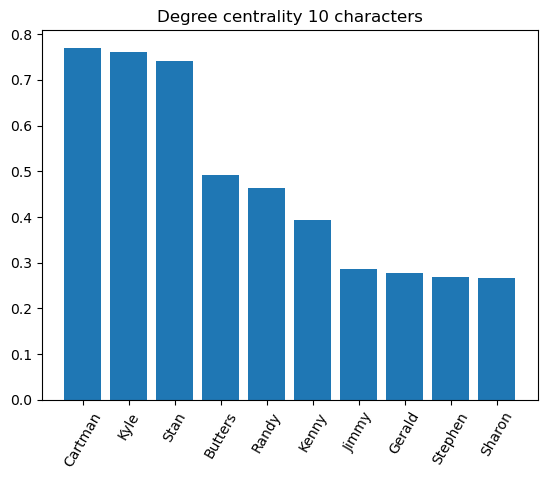

In [50]:
degree_centr = nx.degree_centrality(G)
nx.set_node_attributes(G, degree_centr, 'degree_centr')


plot_top_characters_centrality(degree_centr, top_n)
plt.title(f'Degree centrality {top_n} characters')
plt.show()

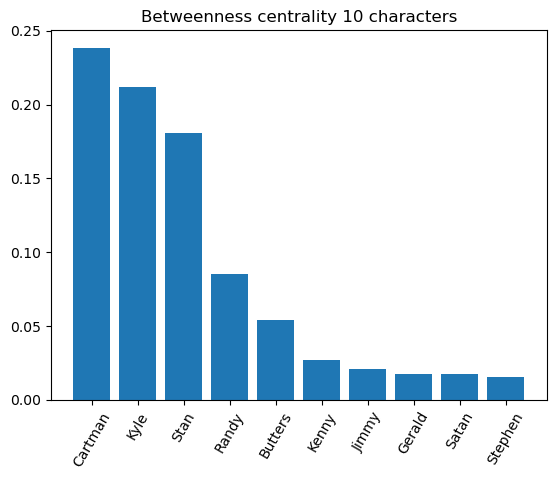

In [51]:
betweenness = nx.betweenness_centrality(G)
nx.set_node_attributes(G, betweenness, 'betweenness')

plot_top_characters_centrality(betweenness, top_n)
plt.title(f'Betweenness centrality {top_n} characters')
plt.show()

The top characters in regards to the centrality measures are very similar. The results are very familiar for someone who follows seen the series. However, the largest difference  is observed in the case of betweenness centrality. The top 3 characters there have much higher centrality than the rest.

### Community detection  

The `community` library is used here and the Louvain algorithm is used to find the communities by maximizing the modularity.

In [79]:
partitions = community_louvain.best_partition(G, random_state=1337)
print(f"{len(set(list(partitions.values())))} communities detected, with modularity {np.round(community_louvain.modularity(partitions, G),4)}")


8 communities detected, with modularity 0.1505


Modularity has a value of $\approx 0.15$, leading to the conclusion that the partitioning is [Suboptimal](http://networksciencebook.com/chapter/9#modularity). Not all the ral communities are detected.

For these communities, we can also create subgraphs that hold information like degree etc from the original graph:

In [80]:
communities_graphs_dict = {i:nx.subgraph(G, members) for i, members in communities_dict.items()}

In addition, the community a character belongs to can be added as an attribute to the graph:

In [81]:
nx.set_node_attributes(G, partitions, 'community')

Create a dictionary that stores the communities as keys and the list of the characters it includes as values:

In [82]:
communities_dict = {i:[char for (char, comm) in partitions.items() if comm==i] for i in set(partitions.values())}

# Sort communities based on the number of members
communities_dict = dict( sorted( communities_dict.items(), key=lambda x: len(x[1]), reverse=True ) )

for community in list(communities_dict.keys()):
    print(f"Community {community} has {len(communities_dict[community])} members")

Community 0 has 83 members
Community 6 has 66 members
Community 4 has 33 members
Community 2 has 29 members
Community 1 has 21 members
Community 7 has 16 members
Community 3 has 3 members
Community 5 has 2 members


In [83]:
# Keep the communities that have members higher than a certain percentile of the total members
percentile_to_keep = 15
perc = np.percentile(np.array([ len(x) for (comm,x) in communities_dict.items() ]), q=percentile_to_keep)

communities_dict_tmp = {}

for comm, members in communities_dict.items():
    if len(members) >= perc:
        communities_dict_tmp[comm] = members
        
communities_dict = communities_dict_tmp
del communities_dict_tmp

In [84]:
for community in list(communities_dict.keys()):
    print(f"Community {community} has {len(communities_dict[community])} members")

Community 0 has 83 members
Community 6 has 66 members
Community 4 has 33 members
Community 2 has 29 members
Community 1 has 21 members
Community 7 has 16 members


We can also print some representative characters for each community:

In [85]:
for community, members in communities_dict.items():
    comm_graph = communities_graphs_dict[community]
    top_deg_chars = {node: deg for node, deg in comm_graph.degree }
    top_deg_chars = list(dict(sorted( top_deg_chars.items(), key=lambda x: x[1], reverse=True )[:7]).keys())
    print(f"Community {community}: {top_deg_chars}")

Community 0: ['Cartman', 'Kyle', 'Stan', 'Butters', 'Kenny', 'Jimmy', 'Clyde']
Community 6: ['Randy', 'Gerald', 'Stephen', 'Sharon', 'Sheila', 'Jimbo', 'Liane']
Community 4: ['Ike', 'Scott', 'Terrance', 'Terry', 'Jesus', 'Rick', 'Muno']
Community 2: ['Mark', 'Kids', 'Boy', 'David', 'Kevin', 'Filmore', 'Jenny']
Community 1: ['Wendy', 'Red', 'Bebe', 'Heidi', 'Lola', 'Annie', 'Nichole']
Community 7: ['Michael', 'Howard', 'Mike', 'Pete', 'Henrietta', 'Grandma', 'Sarah']


### Assortativity   

With [assortativity](http://networksciencebook.com/chapter/7#introduction7) we can see if the hubs in the network tend to link to other hubs or prefer to link to low degree nodes. 

In [91]:
import networkx.algorithms as nx_alg

assort_coef = nx_alg.assortativity.degree_assortativity_coefficient(G)
print(f"Degree assortativity coefficient: {np.round(assort_coef,4)}")

Degree assortativity coefficient: -0.3699


Since the degree assortativity coefficient is negative , the network is  [disassortative](http://networksciencebook.com/chapter/7#measuring-degree), [also](https://en.wikipedia.org/wiki/Assortativity). Looks like the hubs avoid each other and prefer to link to lower degree nodes.  

We can repeat the experiment with the communities as attribute, asking the question: Do community members connect to each other or do they connect to members of different communities?

In [95]:
attr_assort_coef = nx_alg.assortativity.attribute_assortativity_coefficient(G, 'community')
print(f"Attribute (community) assortativity coefficient: {np.round(attr_assort_coef,4)}")

Attribute (community) assortativity coefficient: 0.2071


In the case of communities, it seems the members of each community tend to connect to each other. This coefficient shows an assortative network. However, the value of the coefficinet is  positive, but not very close to 1.

### Visualization of the network  

With the detected communities, and using the edge attribute weight, we can plot a visualization of the network using the `ForceAtlas2` library.

100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:23<00:00, 212.83it/s]


BarnesHut Approximation  took  2.97  seconds
Repulsion forces  took  17.58  seconds
Gravitational forces  took  0.16  seconds
Attraction forces  took  1.84  seconds
AdjustSpeedAndApplyForces step  took  0.56  seconds


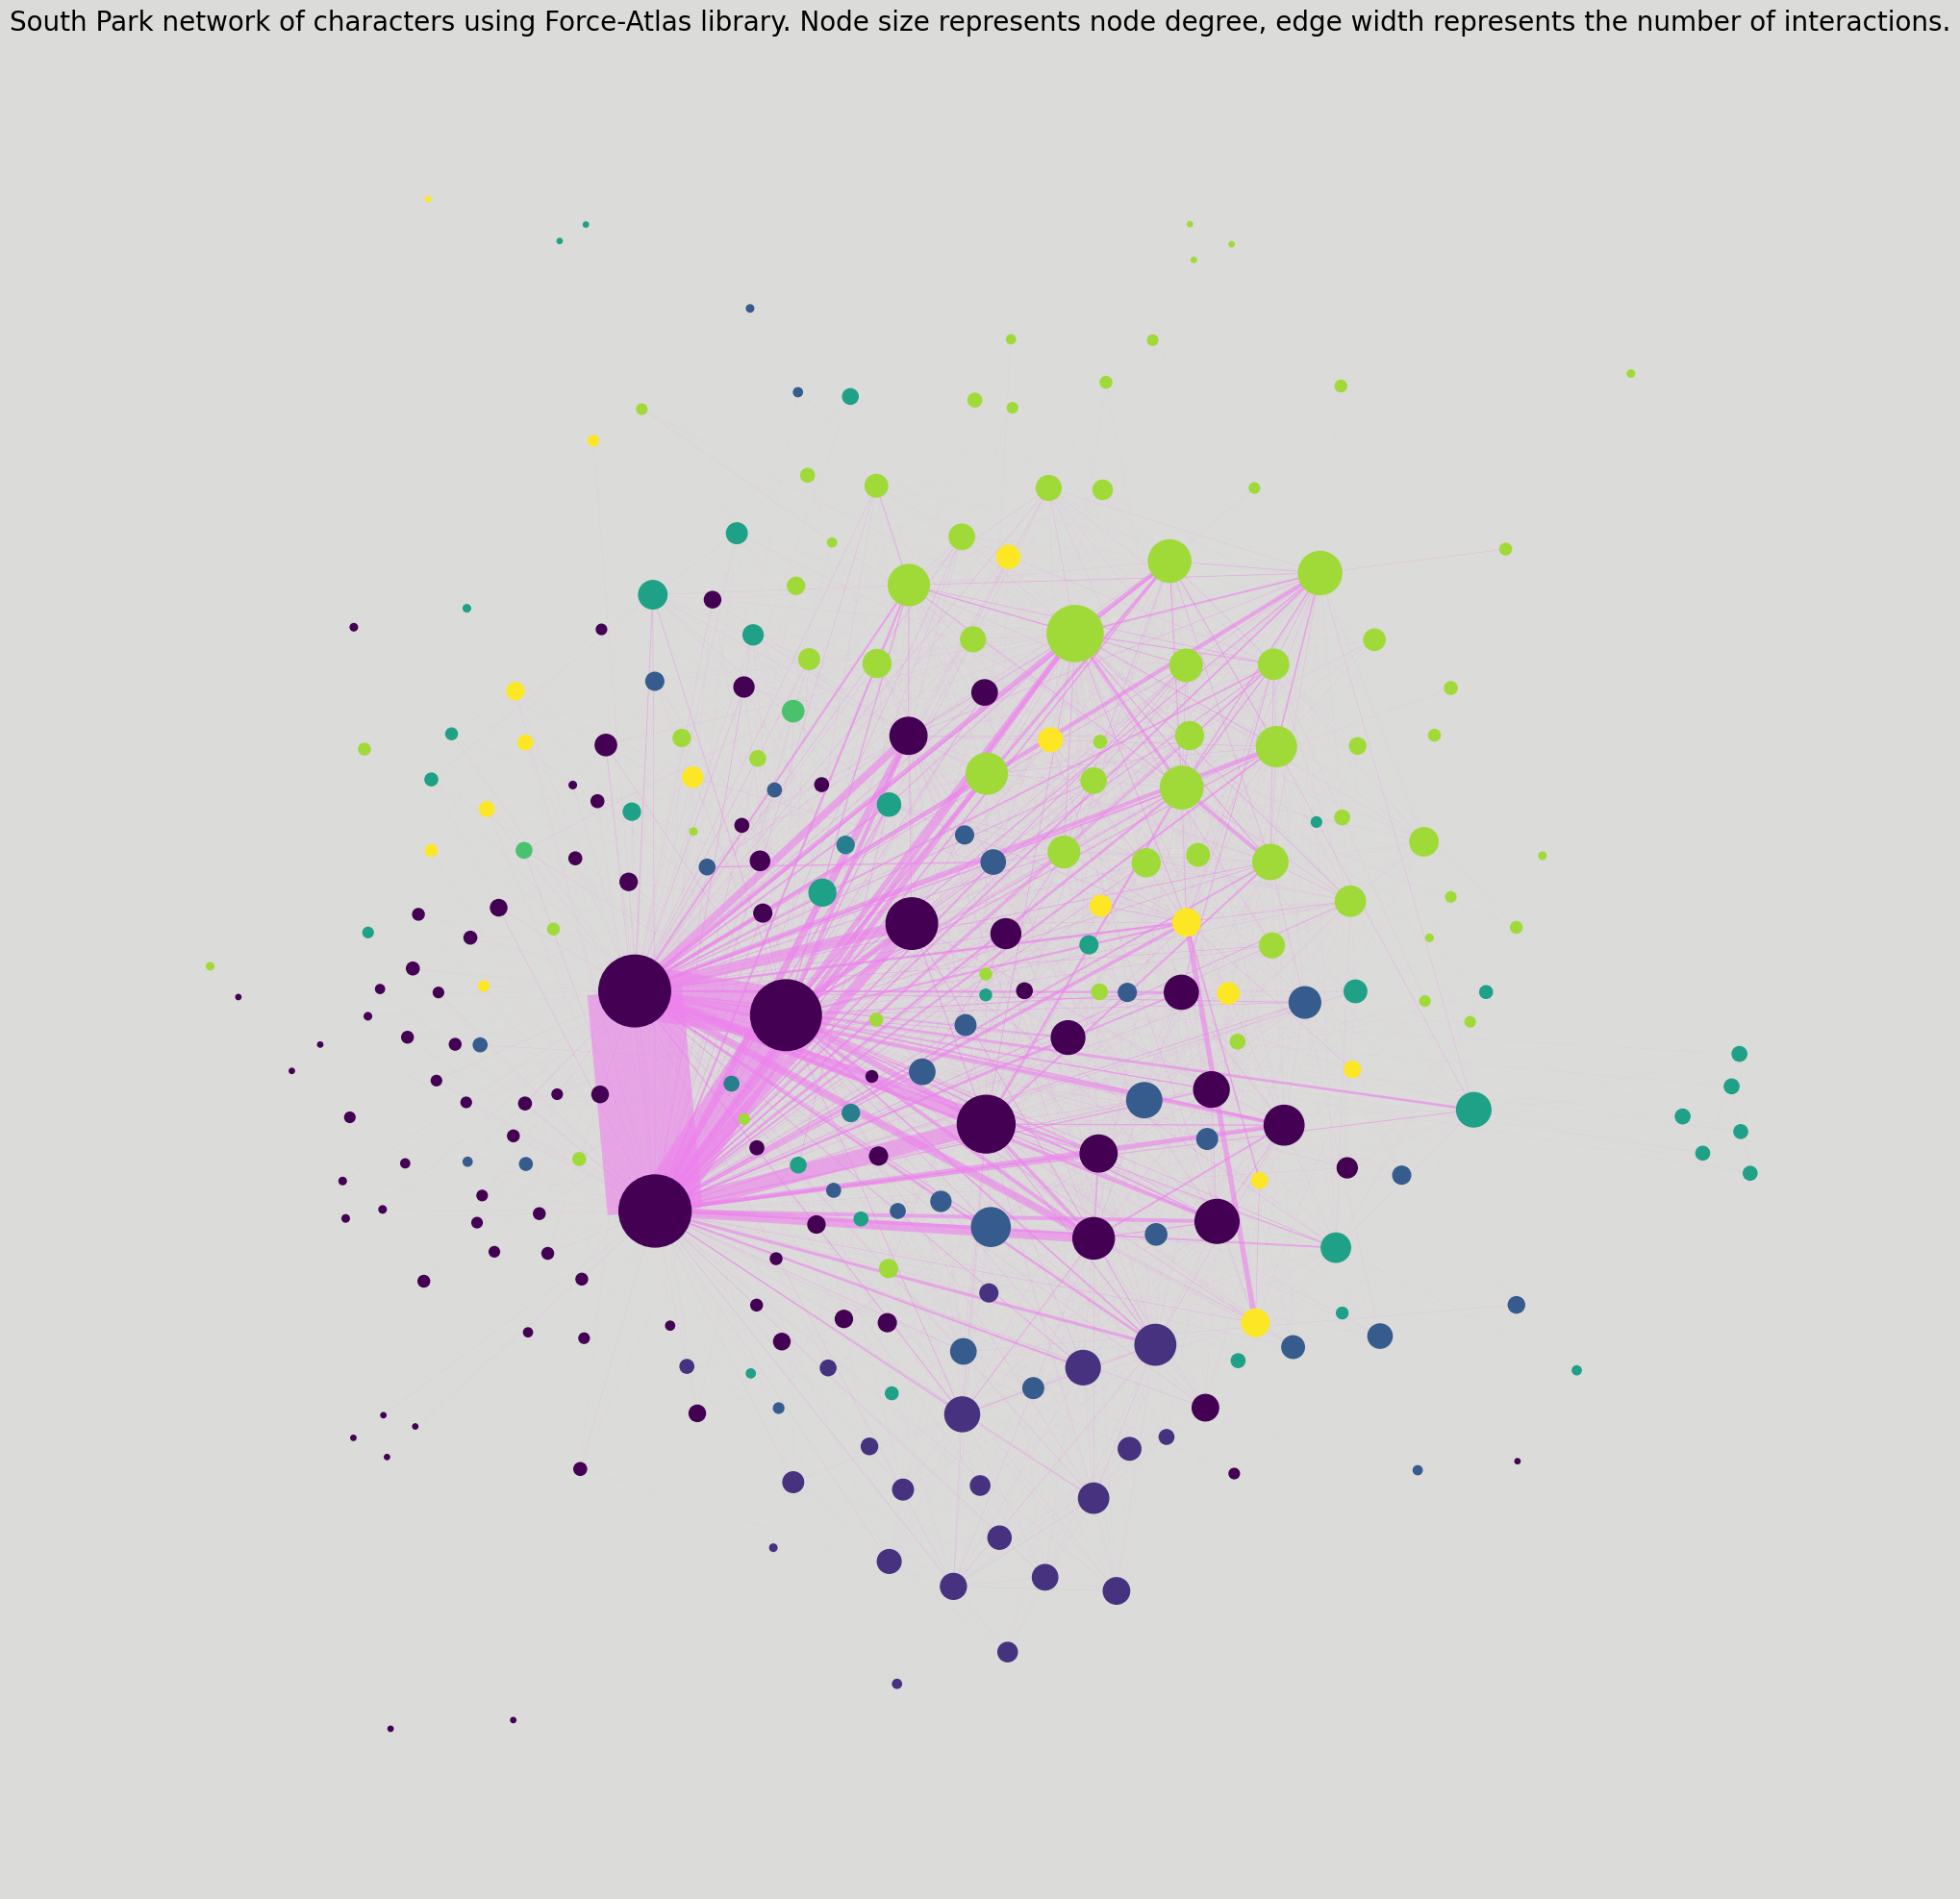

In [99]:
# Visulization of the network
forceatlas2 = ForceAtlas2(
                        # Behavior alternatives
                        outboundAttractionDistribution=False,  # Dissuade hubs
                        linLogMode=False,  # NOT IMPLEMENTED
                        adjustSizes=False,  # Prevent overlap (NOT IMPLEMENTED)
                        edgeWeightInfluence=0.1*1.0,

                        # Performance
                        jitterTolerance=1.0,  # Tolerance
                        barnesHutOptimize=True,
                        barnesHutTheta=1.2,
                        multiThreaded=False,  # NOT IMPLEMENTED

                        # Tuning
                        scalingRatio=30.0,
                        strongGravityMode=False,
                        gravity=20.0,

                        # Log
                        verbose=True)

node_options = {
    # Setting node size based on degree
    'node_size' : [degree*15 for degree in degrees_dist],
    
    # Setting the node color based on the community it belongs to
    'node_color' :  list(partitions.values()),
    
    'alpha': 1
}



edges_options = {
    # Edge colors based on communities
    'width' : [ data["weight"]*0.01 for source, target, data in  G.edges(data=True)],
    'edge_color': 'violet',
    'alpha': 0.6,
}



fig = plt.figure(figsize = [25, 25], facecolor='#dbdbd9')
positions = forceatlas2.forceatlas2_networkx_layout(G, pos=None, iterations=5000)
nx.draw_networkx_nodes(G, positions, **node_options)
nx.draw_networkx_edges(G, positions, **edges_options)
plt.axis('off')

# # Indicating node colors
# y = 0.88 # This is the starting y position for the figure legend
# plt.figtext(1, y, 'Node colors:', size = 17, color = 'black')
# colots_node = ['green','red','purple']
# role_node = ['ally', 'enemy','boss']
# y -= 0.03
# for i in range(3):
#     plt.figtext(1, y, str(role_node[i]), size = 17, color = colots_node[i])
#     y -= 0.03

plt.title("South Park network of characters using Force-Atlas library. Node size represents node degree, edge width represents the number of interactions.", fontsize=20)
plt.show()